<a href="https://colab.research.google.com/github/Cloblak/aipi540_deeplearning/blob/main/1D_CNN_Attempts/CDT1D_TCN_04124MAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install alpaca_trade_api

     |████████████████████████████████| 273 kB 30.4 MB/s 
     |████████████████████████████████| 1.3 MB 82.3 MB/s 
     |████████████████████████████████| 54 kB 1.6 MB/s 
     |████████████████████████████████| 596 kB 49.3 MB/s 
     |████████████████████████████████| 111 kB 80.7 MB/s 
     |████████████████████████████████| 94 kB 1.4 MB/s 
     |████████████████████████████████| 271 kB 76.4 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: msgpack
    Found existing installation: msgpack 1.0.3
    Uninstalling msgpack-1.0.3:
      Successfully uninstalled msgpack-1.0.3


Features To Consider
 - Targets are only predicting sell within market hours, i.e. at 1530, target is prediciting price for 1100 the next day.  Data from pre and post market is taken into consideration, and a sell or buy will be indicated if the price will flucuate after close.

In [2]:
# Import Dependencies
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import alpaca_trade_api as tradeapi
from datetime import datetime, timedelta, tzinfo, timezone, time
import os.path
import ast
import threading
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings

In [3]:
random_seed = 182
torch.manual_seed(random_seed)

In [4]:
PAPER_API_KEY = "PKE39LILN9SL1FMJMFV7"
PAPER_SECRET_KEY = "TkU7fXH6WhP15MewgWlSnQG5RUoHGOPQ7yqlD6xq"
PAPER_BASE_URL = 'https://paper-api.alpaca.markets'

In [5]:
api = tradeapi.REST(PAPER_API_KEY, PAPER_SECRET_KEY, PAPER_BASE_URL, api_version='v2')

In [6]:
def prepost_train_test_validate_offset_data(api, ticker, interval, train_days=180, test_days=60, validate_days=30, offset_days = 0):
    ticker_data_dict = None
    ticker_data_dict = {}
    monthly_data_dict = None
    monthly_data_dict = {}
    interval_loop_data = None
    interval_loop_data = pd.DataFrame()
    stock_data = None
    
    days_to_collect = train_days + test_days + validate_days + offset_days

    TZ = 'US/Eastern'

    start = pd.to_datetime((datetime.now() - timedelta(days=days_to_collect)).strftime("%Y-%m-%d %H:%M"), utc=True)
    end = pd.to_datetime(datetime.now().strftime("%Y-%m-%d %H:%M"), utc=True)

    stock_data = api.get_bars(ticker, interval, start = start.isoformat(), end=end.isoformat(), adjustment="raw").df
    
    interval_loop_data = interval_loop_data.append(stock_data)
    df_start_ref = interval_loop_data.index[0]
    start_str_ref = pd.to_datetime(start, utc=True)

    while start_str_ref.value < ( pd.to_datetime(df_start_ref, utc=True) - pd.Timedelta(days=2.5)).value:
        end_new = pd.to_datetime(interval_loop_data.index[0].strftime("%Y-%m-%d %H:%M"), utc=True).isoformat()
        stock_data_new = None
        stock_data_new = api.get_bars(ticker, interval, start=start, end=end_new, adjustment="raw").df
        #stock_data_new = stock_data_new.reset_index()
        interval_loop_data = interval_loop_data.append(stock_data_new).sort_values(by=['index'], ascending=True)
        df_start_ref = interval_loop_data.index[0]
        
    stock_yr_min_df = interval_loop_data.copy()
    stock_yr_min_df["Open"] = stock_yr_min_df['open']
    stock_yr_min_df["High"]= stock_yr_min_df["high"]
    stock_yr_min_df["Low"] = stock_yr_min_df["low"]
    stock_yr_min_df["Close"] = stock_yr_min_df["close"]
    stock_yr_min_df["Volume"] = stock_yr_min_df["volume"]
    stock_yr_min_df["VolumeWeightedAvgPrice"] = stock_yr_min_df["vwap"]
    stock_yr_min_df["Time"] = stock_yr_min_df.index.tz_convert(TZ)
    stock_yr_min_df.index = stock_yr_min_df.index.tz_convert(TZ)
    final_df = stock_yr_min_df.filter(["Time", "Open", "High", "Low", "Close", "Volume", "VolumeWeightedAvgPrice"], axis = 1)
    
    first_day = final_df.index[0]
    traintest_day = final_df.index[-1] - pd.Timedelta(days= test_days+validate_days+offset_days)
    valtest_day = final_df.index[-1] - pd.Timedelta(days= test_days+offset_days)
    last_day = final_df.index[-1] - pd.Timedelta(days= offset_days)
    training_df =  final_df.loc[first_day:traintest_day] #(data_split - pd.Timedelta(days=1))]
    validate_df = final_df.loc[traintest_day:valtest_day]
    testing_df =  final_df.loc[valtest_day:last_day]
    full_train = final_df.loc[first_day:last_day]
    offset_df =  final_df.loc[last_day:]

    return training_df, validate_df, testing_df, full_train, offset_df, final_df, traintest_day, valtest_day

from datetime import date

train_start = date(2017, 2, 18)
train_end = date(2020, 3, 29)
train_delta = train_end - train_start
print(f'Number of days of Training Data {train_delta.days}')

val_day_num = 400
print(f'Number of days of Validation Data {val_day_num}')

test_start = train_end + timedelta(val_day_num)
test_end = date.today()
test_delta = (test_end - test_start)
print(f'Number of days of Holdout Test Data {test_delta.days}')

ticker = "TSN" # Ticker Symbol to Test
interval = "5Min" # Interval of bars
train_day_int = train_delta.days # Size of training set (Jan 2010 - Oct 2017)
val_day_int = val_day_num # Size of validation set
test_day_int = test_delta.days # Size of test set
offset_day_int = 60 # Number of days to off set the training data
train_raw, val_raw, test_raw, full_raw, offset_raw, complete_raw, traintest_day, testval_day = prepost_train_test_validate_offset_data(api, ticker, 
                                                                                     interval, 
                                                                                     train_days=train_day_int, 
                                                                                     test_days=test_day_int, 
                                                                                     validate_days=val_day_int,
                                                                                     offset_days = offset_day_int)

def timeFilterAndBackfill(df):
  """ 
  Prep df to be filled out for each trading day:
    Time Frame: 0930-1930
    Backfilling NaNs
    Adjusting Volume to Zero if no Trading data is present
      - Assumption is that there were no trades duing that time 

  We will build over lapping arrays by 30 min to give ourselfs more
  oppurtunities to predict during a given trading day 
  """
  
  df = df.between_time('07:29','17:29') # intial sorting of data

  TZ = 'US/Eastern' # define the correct timezone

  start_dateTime = pd.Timestamp(year = df.index[0].year, 
                                month = df.index[0].month, 
                                day = df.index[0].day, 
                                hour = 7, minute = 25, tz = TZ)

  end_dateTime = pd.Timestamp(year = df.index[-1].year, 
                              month = df.index[-1].month, 
                              day = df.index[-1].day, 
                              hour = 17, minute = 35, tz = TZ)

  # build blank index that has ever 5 min interval represented
  dateTime_index = pd.date_range(start_dateTime,
                                end_dateTime, 
                                freq='5min').tolist()

  dateTime_index_df = pd.DataFrame()
  dateTime_index_df["Time"] = dateTime_index 
  filtered_df = pd.merge_asof(dateTime_index_df, df,  
                              on='Time').set_index("Time").between_time('09:29','17:29')

  # create the close array by back filling NA, to represent no change in close
  closeset_list = []
  prev_c = None

  for c in filtered_df["Close"]:

    if prev_c == None:
      if math.isnan(c):
        prev_c = 0
        closeset_list.append(0)
      else:
        prev_c = c
        closeset_list.append(c)
    
    elif prev_c != None:
      if c == prev_c:
        closeset_list.append(c)
      elif math.isnan(c):
        closeset_list.append(prev_c)
      else:
        closeset_list.append(c)
        prev_c = c
    
  filtered_df["Close"] = closeset_list

  # create the volume
  volumeset_list = []
  prev_v = None

  for v in filtered_df["Volume"]:
    
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        volumeset_list.append(0)
      else:
        prev_v = v
        volumeset_list.append(v)

    elif prev_v != None:
      if v == prev_v:
        volumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        volumeset_list.append(0)
        prev_v = 0
      else:
        volumeset_list.append(v)
        prev_v = v

  filtered_df["Volume"] = volumeset_list
  
  adjvolumeset_list = []
  prev_v = None

  for v in filtered_df["VolumeWeightedAvgPrice"]:
    if prev_v == None:
      if math.isnan(v):
        prev_v = 0
        adjvolumeset_list.append(0)
      else:
        prev_v = v
        adjvolumeset_list.append(v)
    elif prev_v != None:
      if v == prev_v:
        adjvolumeset_list.append(0)
        prev_v = v
      elif math.isnan(v):
        adjvolumeset_list.append(0)
        prev_v = 0
      else:
        adjvolumeset_list.append(v)
        prev_v = v

  filtered_df["VolumeWeightedAvgPrice"] = adjvolumeset_list

  preped_df = filtered_df.backfill()

  return preped_df  

Number of days of Training Data 1135
Number of days of Validation Data 400
Number of days of Holdout Test Data 305


In [7]:
train_raw[0:300]

,Time,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
timestamp,,,,,,,
2016-12-21 08:35:00-05:00,2016-12-21 08:35:00-05:00,63.990,63.9900,63.990,63.99,180,63.940889
2016-12-21 09:30:00-05:00,2016-12-21 09:30:00-05:00,61.700,62.4100,61.700,62.40,36971,62.011451
2016-12-21 09:35:00-05:00,2016-12-21 09:35:00-05:00,62.380,62.4400,62.160,62.26,24654,62.317383
2016-12-21 09:40:00-05:00,2016-12-21 09:40:00-05:00,62.265,62.2986,61.990,62.20,18652,62.125614
2016-12-21 09:45:00-05:00,2016-12-21 09:45:00-05:00,62.190,62.2300,62.000,62.22,25056,62.098738
...,...,...,...,...,...,...,...
2016-12-27 14:05:00-05:00,2016-12-27 14:05:00-05:00,62.360,62.3800,62.340,62.38,5377,62.357701
2016-12-27 14:10:00-05:00,2016-12-27 14:10:00-05:00,62.350,62.3800,62.330,62.36,12996,62.358020
2016-12-27 14:15:00-05:00,2016-12-27 14:15:00-05:00,62.360,62.4200,62.350,62.35,11428,62.375091


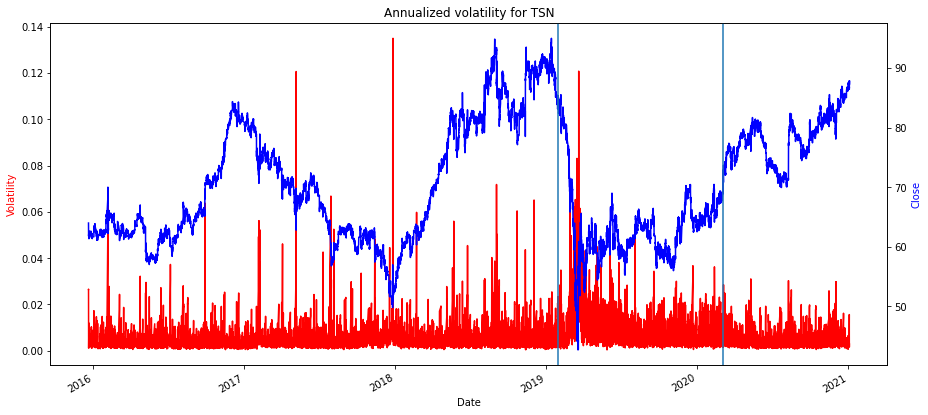

In [8]:
def buildTargets_VolOnly(full_df = full_raw, train_observations = train_raw.shape[0], 
                         val_observations = val_raw.shape[0], 
                         test_observations = test_raw.shape[0], 
                         alph = .55, volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test data and return the targets.
  Volitility will be calculated over the 252 5min incriments 
  The Target shift is looking at 2 hours shift from current time
  """

  returns = np.log(full_df['Close']/(full_df['Close'].shift()))
  returns.fillna(0, inplace=True)
  volatility = returns.rolling(window=(volity_int)).std()*np.sqrt(volity_int)



  return volatility
  #return train_targets, val_targets, test_targets, full_targets

volatility = buildTargets_VolOnly()

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
volatility.plot(ax=ax1, color = "red")
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility', color = "red")
ax1.set_title(f'Annualized volatility for {ticker}')
ax2 = ax1.twinx()
full_raw.Close.plot(ax=ax2, color = "blue")
ax2.set_ylabel('Close', color = "blue")
ax2.axvline(x=full_raw.index[train_raw.shape[0]])
ax2.axvline(x=full_raw.index[val_raw.shape[0]+train_raw.shape[0]])
plt.show()

In [9]:
train = timeFilterAndBackfill(train_raw)
val = timeFilterAndBackfill(val_raw)
test = timeFilterAndBackfill(test_raw)

train = train[train.index.dayofweek <= 4].copy()
val = val[val.index.dayofweek <= 4].copy()
test = test[test.index.dayofweek <= 4].copy()

train["Open"] = np.where((train["Volume"] == 0), train["Close"], train["Open"])
train["High"] = np.where((train["Volume"] == 0), train["Close"], train["High"])
train["Low"] = np.where((train["Volume"] == 0), train["Close"], train["Low"])

val["Open"] = np.where((val["Volume"] == 0), val["Close"], val["Open"])
val["High"] = np.where((val["Volume"] == 0), val["Close"], val["High"])
val["Low"] = np.where((val["Volume"] == 0), val["Close"], val["Low"])

test["Open"] = np.where((test["Volume"] == 0), test["Close"], test["Open"])
test["High"] = np.where((test["Volume"] == 0), test["Close"], test["High"])
test["Low"] = np.where((test["Volume"] == 0), test["Close"], test["Low"])

def strided_axis0(a, L, overlap=1):
    if L==overlap:
        raise Exception("Overlap arg must be smaller than length of windows")
    S = L - overlap
    nd0 = ((len(a)-L)//S)+1
    if nd0*S-S!=len(a)-L:
        warnings.warn("Not all elements were covered")
    m,n = a.shape
    s0,s1 = a.strides
    return np.lib.stride_tricks.as_strided(a, shape=(nd0,L,n), strides=(S*s0,s0,s1))

# OLDER CODE WITHOUT OVERLAP OF LABELING
# def blockshaped(arr, nrows, ncols):
#     """
#     Return an array of shape (n, nrows, ncols) where
#     n * nrows * ncols = arr.size

#     If arr is a 2D array, the returned array should look like n subblocks with
#     each subblock preserving the "physical" layout of arr.
#     """
#     h, w = arr.shape
#     assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
#     assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
#     return np.flip(np.rot90((arr.reshape(h//nrows, nrows, -1, ncols)
#                .swapaxes(1,2)
#                .reshape(-1, nrows, ncols)), axes = (1, 2)), axis = 1)


def blockshaped(arr, nrows, ncols, overlapping_5min_intervals = 12):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """

    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"

    return np.flip(np.rot90((strided_axis0(arr, 24, overlap=overlapping_5min_intervals).reshape(-1, nrows, ncols)), axes = (1, 2)), axis = 1)

train_tonp = train[["Open", "High", "Low", "Close", "Volume"]]
val_tonp = val[["Open", "High", "Low", "Close", "Volume"]]
test_tonp = test[["Open", "High", "Low", "Close", "Volume"]]
train_array = train_tonp.to_numpy()
val_array = val_tonp.to_numpy()
test_array = test_tonp.to_numpy()

X_train_pre_final = blockshaped(train_array, 24, 5, overlapping_5min_intervals = 12)
X_val_pre_final = blockshaped(val_array, 24, 5, overlapping_5min_intervals = 12)
X_test_pre_final = blockshaped(test_array, 24, 5, overlapping_5min_intervals = 12)

# X_train_pre_final = blockshaped(train_array, 24, 5)
# X_val_pre_final = blockshaped(val_array, 24, 5)
# X_test_pre_final = blockshaped(test_array, 24, 5)

In [10]:
np.set_printoptions(edgeitems=10,linewidth=580)
X_train_pre_final[0]

array([[6.17000e+01, 6.23800e+01, 6.22650e+01, 6.21900e+01, 6.21956e+01, 6.22800e+01, 6.24763e+01, 6.26710e+01, 6.27950e+01, 6.28300e+01, 6.28950e+01, 6.27400e+01, 6.28300e+01, 6.29850e+01, 6.29300e+01, 6.30900e+01, 6.27600e+01, 6.26100e+01, 6.25600e+01, 6.25500e+01, 6.25000e+01, 6.25200e+01, 6.25600e+01, 6.24100e+01],
       [6.24100e+01, 6.24400e+01, 6.22986e+01, 6.22300e+01, 6.22900e+01, 6.24900e+01, 6.27200e+01, 6.28100e+01, 6.28800e+01, 6.29300e+01, 6.28950e+01, 6.28800e+01, 6.30300e+01, 6.30100e+01, 6.31000e+01, 6.31000e+01, 6.27600e+01, 6.26400e+01, 6.26500e+01, 6.25700e+01, 6.25300e+01, 6.26100e+01, 6.25800e+01, 6.24100e+01],
       [6.17000e+01, 6.21600e+01, 6.19900e+01, 6.20000e+01, 6.21900e+01, 6.22800e+01, 6.24600e+01, 6.26700e+01, 6.27500e+01, 6.27800e+01, 6.27400e+01, 6.25600e+01, 6.28300e+01, 6.29300e+01, 6.29300e+01, 6.27700e+01, 6.26000e+01, 6.25350e+01, 6.25375e+01, 6.24400e+01, 6.24900e+01, 6.25200e+01, 6.24200e+01, 6.23300e+01],
       [6.24000e+01, 6.22600e+01, 6.2

In [11]:
train_tonp[0:24]

,Open,High,Low,Close,Volume
Time,,,,,
2016-12-21 09:30:00-05:00,61.7000,62.4100,61.7000,62.4000,36971.0
2016-12-21 09:35:00-05:00,62.3800,62.4400,62.1600,62.2600,24654.0
2016-12-21 09:40:00-05:00,62.2650,62.2986,61.9900,62.2000,18652.0
2016-12-21 09:45:00-05:00,62.1900,62.2300,62.0000,62.2200,25056.0
2016-12-21 09:50:00-05:00,62.1956,62.2900,62.1900,62.2900,33676.0
2016-12-21 09:55:00-05:00,62.2800,62.4900,62.2800,62.4900,20793.0
2016-12-21 10:00:00-05:00,62.4763,62.7200,62.4600,62.6850,59461.0
2016-12-21 10:05:00-05:00,62.6710,62.8100,62.6700,62.8000,24927.0
2016-12-21 10:10:00-05:00,62.7950,62.8800,62.7500,62.8300,26866.0


In [12]:
X_train_pre_final[1]

array([[6.28300e+01, 6.29850e+01, 6.29300e+01, 6.30900e+01, 6.27600e+01, 6.26100e+01, 6.25600e+01, 6.25500e+01, 6.25000e+01, 6.25200e+01, 6.25600e+01, 6.24100e+01, 6.23500e+01, 6.24100e+01, 6.24300e+01, 6.23700e+01, 6.23650e+01, 6.22500e+01, 6.22800e+01, 6.23300e+01, 6.22450e+01, 6.22250e+01, 6.22100e+01, 6.21400e+01],
       [6.30300e+01, 6.30100e+01, 6.31000e+01, 6.31000e+01, 6.27600e+01, 6.26400e+01, 6.26500e+01, 6.25700e+01, 6.25300e+01, 6.26100e+01, 6.25800e+01, 6.24100e+01, 6.24600e+01, 6.24500e+01, 6.24300e+01, 6.23900e+01, 6.23700e+01, 6.22850e+01, 6.23500e+01, 6.23300e+01, 6.22900e+01, 6.22500e+01, 6.22150e+01, 6.21900e+01],
       [6.28300e+01, 6.29300e+01, 6.29300e+01, 6.27700e+01, 6.26000e+01, 6.25350e+01, 6.25375e+01, 6.24400e+01, 6.24900e+01, 6.25200e+01, 6.24200e+01, 6.23300e+01, 6.23400e+01, 6.24000e+01, 6.23600e+01, 6.23250e+01, 6.22700e+01, 6.22050e+01, 6.22800e+01, 6.22400e+01, 6.22200e+01, 6.22150e+01, 6.21400e+01, 6.21200e+01],
       [6.29800e+01, 6.29350e+01, 6.3

In [13]:
# create target from OHLC and Volume Data
###### THIS IS FOR 3 CLASS FROM PAPER ########
def buildTargets(obs_array,  
                 alph = .55, 
                 volity_int = 10):

  """ 
  This function will take a complete set of train, val, and test 
  data and return the targets. Volitility will be calculated over 
  the 24 5min incriments. The Target shift is looking at 2 hours 
  shift from current time

  shift_2hour = The amount of time the data interval take to equal 2 hours 
                (i.e. 5 min data interval is equal to 24)
  alph = The alpha value for calculating the shift in price
  volity_int = the number of incriments used to calculate volitility 
  """

  target_close_list =[]

  for arr in obs_array:
    target_close_list.append(arr[3][-1])
  
  target_close_df = pd.DataFrame()
  target_close_df["Close"] = target_close_list

  target_close_df["Volitility"] = target_close_df["Close"].rolling(volity_int).std()

  # print(len(volatility), len(target_close_df["Close"]))

  
  targets = [0] * len(target_close_df.Close)

  targets = np.where(target_close_df.Close.shift(-1) >= (target_close_df.Close * (1 + alph * target_close_df["Volitility"])), 
           2, targets)
  
  targets = np.where(target_close_df.Close.shift(-1) <= (target_close_df.Close * (1 - alph * target_close_df["Volitility"])), 
           1, targets)

  return targets


#####DISREGUARD THE VOLITLITY######
# def buildTargets(obs_array,  
  #                alph = .55, 
  #                volity_int = 10):

  # """ 
  # This function will take a complete set of train, val, and test 
  # data and return the targets. Volitility will be calculated over 
  # the 24 5min incriments. The Target shift is looking at 2 hours 
  # shift from current time

  # shift_2hour = The amount of time the data interval take to equal 2 hours 
  #               (i.e. 5 min data interval is equal to 24)
  # alph = The alpha value for calculating the shift in price
  # volity_int = the number of incriments used to calculate volitility 
  # """

  # target_close_list =[]

  # for arr in obs_array:
  #   target_close_list.append(arr[3][-1])
  
  # target_close_df = pd.DataFrame()
  # target_close_df["Close"] = target_close_list

  # target_close_df["Volitility"] = target_close_df["Close"].rolling(volity_int).std()
  
  # targets = [0] * len(target_close_df.Close)

  # targets = np.where(target_close_df.Close.shift(-1) >= (target_close_df.Close * (1 + alph)), 
  #          2, targets)
  
  # targets = np.where(target_close_df.Close.shift(-1) <= (target_close_df.Close * (1 - alph)), 
  #          1, targets)

  # return targets

  #####Binary Class######
# def buildTargets(obs_array,  
#                  alph = .55, 
#                  volity_int = 10):

#   """ 
#   This function will take a complete set of train, val, and test 
#   data and return the targets. Volitility will be calculated over 
#   the 24 5min incriments. The Target shift is looking at 2 hours 
#   shift from current time

#   shift_2hour = The amount of time the data interval take to equal 2 hours 
#                 (i.e. 5 min data interval is equal to 24)
#   alph = The alpha value for calculating the shift in price
#   volity_int = the number of incriments used to calculate volitility 
#   """

#   target_close_list =[]

#   for arr in obs_array:
#     target_close_list.append(arr[3][-1])
  
#   target_close_df = pd.DataFrame()
#   target_close_df["Close"] = target_close_list

#   target_close_df["Volitility"] = target_close_df["Close"].rolling(volity_int).std()

#   # print(len(volatility), len(target_close_df["Close"]))

  
#   targets = [0] * len(target_close_df.Close)

#   targets = np.where(target_close_df.Close.shift(-1) >= (target_close_df.Close * (1 + alph)), 
#            1, targets)

#   return targets

In [14]:
volity_val = 10
alph = .0055
y_train_pre_final = buildTargets(X_train_pre_final, alph=alph,  volity_int = volity_val)
y_val_pre_final = buildTargets(X_val_pre_final, alph=alph, volity_int = volity_val)
y_test_pre_final = buildTargets(X_test_pre_final, alph=alph, volity_int = volity_val)

In [15]:
def get_class_distribution(obj):
    count_dict = {
        "up": 0,
        "down": 0,
        "flat": 0,
    }
    
    for i in obj:
        if i == 2: 
            count_dict['up'] += 1
        elif i == 1: 
            count_dict['down'] += 1
        elif i == 0: 
            count_dict['flat'] += 1             
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

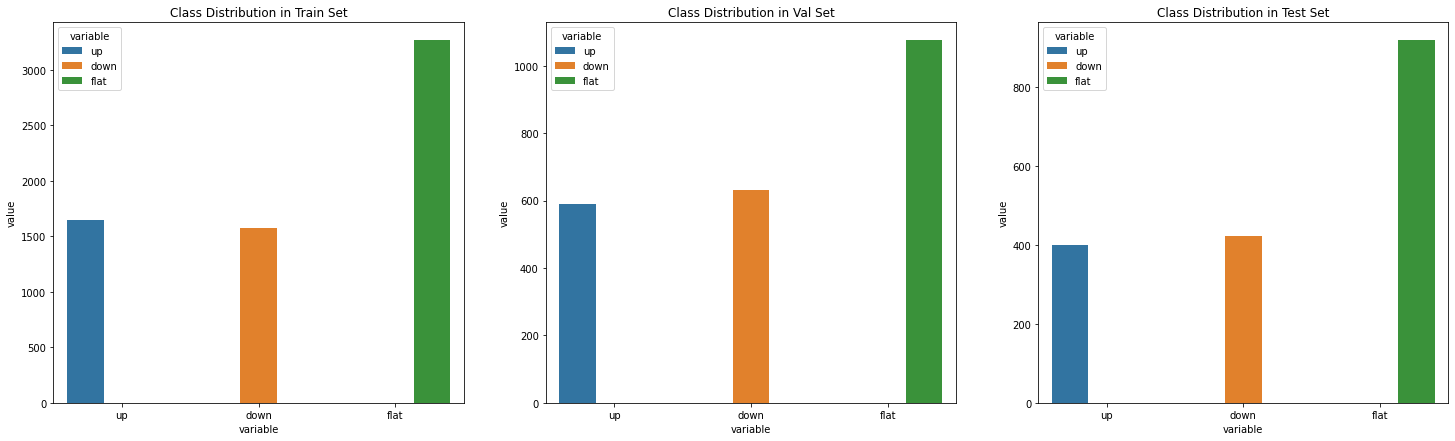

In [16]:
bfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test_pre_final)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [17]:
def createFinalData_RemoveLateAfternoonData(arr, labels):

  assert arr.shape[0] == len(labels), "X data do not match length of y labels"

  step_count = 0
  filtered_y_labels = []

  for i in range(arr.shape[0]):

    if i == 0:
      final_arr = arr[i]
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1

    elif i == 1:

      final_arr = np.stack((final_arr, arr[i]))
      filtered_y_labels.append(labels[i])
      step_count += 1

    elif step_count == 0: 
      final_arr = np.vstack((final_arr, arr[i][None]))
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1
    
    elif (step_count) % 5 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count += 1

    elif (step_count) % 6 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count += 1

    elif (step_count) % 7 == 0:
      #print(f'skipping {i} array, step_count: {step_count}')
      step_count = 0
    
    else:
      final_arr = np.vstack((final_arr, arr[i][None]))
      filtered_y_labels.append(labels[i])
      #print(f'Appending index {i}, step_count: {step_count}')
      step_count += 1
  
  return final_arr, filtered_y_labels

X_train, y_train = createFinalData_RemoveLateAfternoonData(X_train_pre_final, y_train_pre_final)
X_val, y_val = createFinalData_RemoveLateAfternoonData(X_val_pre_final, y_val_pre_final)
X_test, y_test = createFinalData_RemoveLateAfternoonData(X_test_pre_final, y_test_pre_final)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [18]:
# Check it arrays are made correctly
train[12:48]

,Open,High,Low,Close,Volume,VolumeWeightedAvgPrice
Time,,,,,,
2016-12-21 10:30:00-05:00,62.830,63.0300,62.8300,62.9800,78183.0,62.921556
2016-12-21 10:35:00-05:00,62.985,63.0100,62.9300,62.9350,33045.0,62.974453
2016-12-21 10:40:00-05:00,62.930,63.1000,62.9300,63.1000,28973.0,63.027256
2016-12-21 10:45:00-05:00,63.090,63.1000,62.7700,62.7700,37917.0,62.952890
2016-12-21 10:50:00-05:00,62.760,62.7600,62.6000,62.6010,62178.0,62.738510
2016-12-21 10:55:00-05:00,62.610,62.6400,62.5350,62.5500,20417.0,62.581453
2016-12-21 11:00:00-05:00,62.560,62.6500,62.5375,62.5500,31110.0,62.589809
2016-12-21 11:05:00-05:00,62.550,62.5700,62.4400,62.4700,26520.0,62.495128
2016-12-21 11:10:00-05:00,62.500,62.5300,62.4900,62.5100,12015.0,62.506717


In [19]:
np.set_printoptions(threshold=200)
y_train_pre_final[50:75]

array([0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 0])

In [20]:
######
# Code fro scaling at a later date
######

# from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler

scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = StandardScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_val.shape[1]):
    X_val[:, i, :] = scalers[i].transform(X_val[:, i, :]) 

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 
    

Text(0.5, 1.0, 'Class Distribution in Test Set')

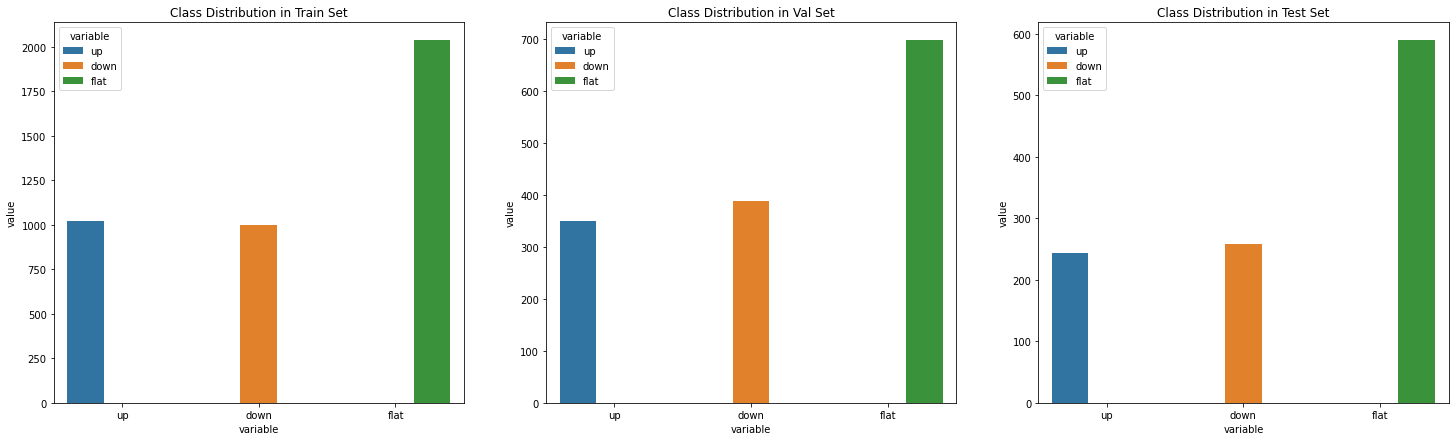

In [21]:
vbfig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [28]:
from typing import List, Tuple

import keras.backend as K
import keras.layers
from keras import optimizers
from tensorflow.keras.layers import Layer, Input
from keras.layers import Activation, Lambda
from keras.layers import Conv1D, SpatialDropout1D
from keras.layers import Convolution1D, Dense
from keras.models import Input, Model


def residual_block(x, dilation_rate, nb_filters, kernel_size, padding, activation='relu', dropout_rate=0):
    # type: (Layer, int, int, int, str, str, float) -> Tuple[Layer, Layer]
    """Defines the residual block for the WaveNet TCN
    Args:
        x: The previous layer in the model
        dilation_rate: The dilation power of 2 we are using for this residual block
        nb_filters: The number of convolutional filters to use in this block
        kernel_size: The size of the convolutional kernel
        padding: The padding used in the convolutional layers, 'same' or 'causal'.
        activation: The final activation used in o = Activation(x + F(x))
        dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
    Returns:
        A tuple where the first element is the residual model layer, and the second
        is the skip connection.
    """
    prev_x = x
    for k in range(2):
        x = Conv1D(filters=nb_filters,
                   kernel_size=kernel_size,
                   dilation_rate=dilation_rate,
                   padding=padding)(x)
        # x = BatchNormalization()(x)  # TODO should be WeightNorm here.
        x = Activation('relu')(x)
        x = SpatialDropout1D(rate=dropout_rate)(x)

    # 1x1 conv to match the shapes (channel dimension).
    prev_x = Conv1D(nb_filters, 1, padding='same')(prev_x)
    res_x = keras.layers.add([prev_x, x])
    res_x = Activation(activation)(res_x)
    return res_x, x


def process_dilations(dilations):
    def is_power_of_two(num):
        return num != 0 and ((num & (num - 1)) == 0)

    if all([is_power_of_two(i) for i in dilations]):
        return dilations

    else:
        new_dilations = [2 ** i for i in dilations]
        return new_dilations


class TCN_2D(Layer):
    """Creates a TCN layer.
        Input shape:
            A tensor of shape (batch_size, timesteps, input_dim).
        Args:
            nb_filters: The number of filters to use in the convolutional layers.
            kernel_size: The size of the kernel to use in each convolutional layer.
            dilations: The list of the dilations. Example is: [1, 2, 4, 8, 16, 32, 64].
            nb_stacks : The number of stacks of residual blocks to use.
            padding: The padding to use in the convolutional layers, 'causal' or 'same'.
            use_skip_connections: Boolean. If we want to add skip connections from input to each residual block.
            return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
            activation: The activation used in the residual blocks o = Activation(x + F(x)).
            dropout_rate: Float between 0 and 1. Fraction of the input units to drop.
            name: Name of the model. Useful when having multiple TCN.
        Returns:
            A TCN layer.
        """

    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=[1, 2, 4, 8, 16, 32],
                 padding='causal',
                 use_skip_connections=True,
                 dropout_rate=0.0,
                 return_sequences=False,
                 activation='linear',
                 name='tcn'):
        self.name = name
        self.return_sequences = return_sequences
        self.dropout_rate = dropout_rate
        self.use_skip_connections = use_skip_connections
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters
        self.activation = activation
        self.padding = padding

        if padding != 'causal' and padding != 'same':
            raise ValueError("Only 'causal' or 'same' padding are compatible for this layer.")

        if not isinstance(nb_filters, int):
            print('An interface change occurred after the version 2.1.2.')
            print('Before: tcn.TCN(x, return_sequences=False, ...)')
            print('Now should be: tcn.TCN(return_sequences=False, ...)(x)')
            print('The alternative is to downgrade to 2.1.2 (pip install keras-tcn==2.1.2).')
            raise Exception()

    def __call__(self, inputs):
        x = inputs
        # 1D FCN.
        x = Convolution1D(self.nb_filters, 1, padding=self.padding)(x)
        skip_connections = []
        for s in range(self.nb_stacks):
            for d in self.dilations:
                x, skip_out = residual_block(x,
                                             dilation_rate=d,
                                             nb_filters=self.nb_filters,
                                             kernel_size=self.kernel_size,
                                             padding=self.padding,
                                             activation=self.activation,
                                             dropout_rate=self.dropout_rate)
                skip_connections.append(skip_out)
        if self.use_skip_connections:
            x = keras.layers.add(skip_connections)
        if not self.return_sequences:
            x = Lambda(lambda tt: tt[:, -1, :])(x)
        return x

# KERAS 1D Model

In [29]:
###### ONLY EXECUTE FOR KERAS 2D CNN #####

X_train_1d = X_train.reshape(X_train.shape[0], 
                          X_train.shape[1], 
                          X_train.shape[2],
                          )
X_val_1d = X_val.reshape(X_val.shape[0],
                          X_val.shape[1], 
                          X_val.shape[2],
                          )
X_test_1d = X_test.reshape(X_test.shape[0],
                          X_test.shape[1], 
                          X_test.shape[2],
                          )

from tensorflow.keras.utils import to_categorical

y_train_final = to_categorical(y_train, 3)
y_val_final = to_categorical(y_val, 3)
y_test_final = to_categorical(y_test, 3)


In [30]:
print(f'X Train Length {X_train_1d.shape}, y Train Label Length {y_train_final.shape}')
print(f'X Val Length {X_val_1d.shape}, y Val Label Length {y_val_final.shape}')
print(f'X Test Length {X_test_1d.shape}, y Test Label Length {y_test_final.shape}')

X Train Length (4055, 5, 24), y Train Label Length (4055, 3)
X Val Length (1435, 5, 24), y Val Label Length (1435, 3)
X Test Length (1090, 5, 24), y Test Label Length (1090, 3)


In [31]:
import tensorflow as tf
import keras.backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers import Flatten
from keras.layers import Dropout
from keras.models import Input, Model
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam


# import TCN layer

In [32]:
# Simple Model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],X_train.shape[2])))
# model.add(TCN(return_sequences=True, nb_filters=32, kernel_size=4))
model.add(TCN_2D(return_sequences=False, nb_filters=64, kernel_size=3))
# model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
# model.add(MaxPooling1D(pool_size=3, strides=4, padding='same'))
# model.add(Dropout(0.7))
# model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
# model.add(Dropout(0.7))
# model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
# model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(1000,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(3,activation="softmax"))
model.summary()

AttributeError: ignored

In [ ]:
adam = Adam(learning_rate=0.001, decay=0.0001)
nadam = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"]) 

In [ ]:
from keras.callbacks import EarlyStopping, Callback

callback = EarlyStopping(monitor='loss', patience=5, min_delta=0.0001)

batch_size = 12
hist = model.fit(X_train_1d, y_train_final, batch_size=batch_size, epochs=15, callbacks=[callback], validation_data=(X_val_1d, y_val_final)) #, class_weight={0:1, 1:1.5})

Epoch 1/15
339/339 [==============================] - 3s 9ms/step - loss: 0.0584 - accuracy: 0.9685 - val_loss: 2.9691 - val_accuracy: 0.4021
Epoch 2/15
339/339 [==============================] - 3s 9ms/step - loss: 0.0335 - accuracy: 0.9830 - val_loss: 3.4359 - val_accuracy: 0.4084
Epoch 3/15
339/339 [==============================] - 3s 9ms/step - loss: 0.0333 - accuracy: 0.9833 - val_loss: 3.3933 - val_accuracy: 0.4077
Epoch 4/15
339/339 [==============================] - 3s 9ms/step - loss: 0.0336 - accuracy: 0.9850 - val_loss: 3.5158 - val_accuracy: 0.4049
Epoch 5/15
339/339 [==============================] - 3s 9ms/step - loss: 0.0362 - accuracy: 0.9820 - val_loss: 3.5571 - val_accuracy: 0.4021
Epoch 6/15
339/339 [==============================] - 3s 10ms/step - loss: 0.0427 - accuracy: 0.9800 - val_loss: 3.5612 - val_accuracy: 0.3986
Epoch 7/15
339/339 [==============================] - 3s 9ms/step - loss: 0.0255 - accuracy: 0.9884 - val_loss: 3.6794 - val_accuracy: 0.4070
Epoch

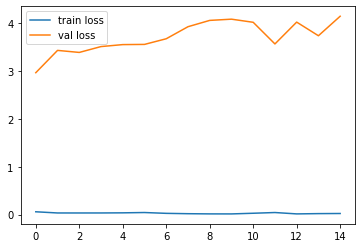

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

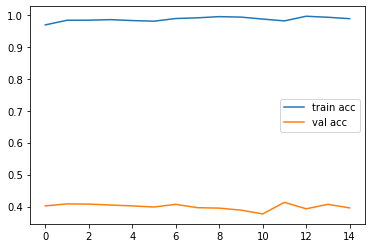

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
y_pred = model.predict(X_test_1d)

In [ ]:
# Calculate the accuracy
test_preds = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_final, axis=1)
test_acc = np.sum(test_preds == y_true)/y_true.shape[0]

# Recall for each class
recall_vals = []
for i in range(3):
    class_idx = np.argwhere(y_true==i)
    total = len(class_idx)
    correct = np.sum(test_preds[class_idx]==i)
    recall = correct / total
    recall_vals.append(recall)

classes = [0,1, 2]
# Calculate the test set accuracy and recall for each class
print('Test set accuracy is {:.3f}'.format(test_acc))
for i in range(3):
    print('For class {}, recall is {:.3f}'.format(classes[i],recall_vals[i]))

print("Accuracy is {:.3f}".format(test_acc))
# print("Weighted F score is {:.3f}".format(calculate_weighted_f_score(y_true, y_pred)))

Test set accuracy is 0.424
For class 0, recall is 0.603
For class 1, recall is 0.198
For class 2, recall is 0.227
Accuracy is 0.424


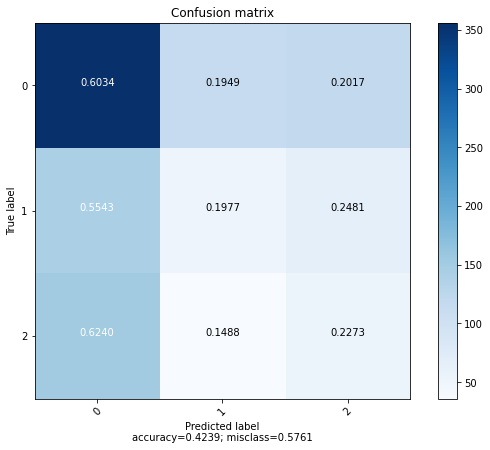

              precision    recall  f1-score   support

        flat     0.5477    0.6034    0.5742       590
        down     0.2525    0.1977    0.2217       258
          up     0.2311    0.2273    0.2292       242

    accuracy                         0.4239      1090
   macro avg     0.3438    0.3428    0.3417      1090
weighted avg     0.4075    0.4239    0.4142      1090



In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

nb_classes = 3

# Confusion matrix
conf_mat=confusion_matrix(y_true, np.argmax(y_pred, axis=-1))
plot_confusion_matrix(conf_mat, [0,1,2])

from sklearn.metrics import precision_score

precision_score(y_true, np.argmax(y_pred, axis=-1), average='weighted')

from sklearn.metrics import classification_report

print(classification_report(y_true, np.argmax(y_pred, axis=-1), target_names=["flat", "down", "up"], digits=4))

In [ ]:
def calculate_weighted_f_score(y_true, y_pred):
  test_preds = np.argmax(y_pred, axis=-1)
  Ntu = sum((test_preds == 2) & (y_true == 2))
  Ntd = sum((test_preds == 1) & (y_true == 1))
  Ntf = sum((test_preds == 0) & (y_true == 0))
  Ewutd = sum((test_preds == 2) & (y_true == 1))
  Ewdtu = sum((test_preds == 1) & (y_true == 2))
  Ewutf = sum((test_preds == 2) & (y_true == 0))
  Ewdtf = sum((test_preds == 1) & (y_true == 0))
  Ewftu = sum((test_preds == 0) & (y_true == 2))
  Ewftd = sum((test_preds == 0) & (y_true == 1))

  beta_1 = 0.5
  beta_2 = 0.125
  beta_3 = 0.125

  Ntp = Ntu + Ntd + beta_3**2 * Ntf
  E1 = Ewutd + Ewdtu
  E2 = Ewutf + Ewdtf
  E3 = Ewftu + Ewftd

  F = (1 + beta_1**2 + beta_2**2) * Ntp / ((1+beta_1**2+beta_2**2) * Ntp + E1 + beta_1**2 * E2 + beta_2**2 * E3)
  return  F

print(f'Weight CDT F Score: {calculate_weighted_f_score(y_true, y_pred)}')

Weight CDT F Score: 0.4640187680724535


In [ ]:
print(X_train.shape[1],X_train.shape[2])

5 24


In [ ]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(MaxPooling1D(pool_size=3, strides=4, padding='same'))
model.add(Dropout(0.7))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
model.add(Dropout(0.7))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))
model.add(Dropout(0.7))
model.add(Flatten())
model.add(Dense(1000,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(2,activation="softmax"))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 5, 32)             2336      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 2, 32)            0         
 g1D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 2, 32)             0         
                                                                 
 conv1d_19 (Conv1D)          (None, 2, 64)             6208      
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 1, 64)            0         
 g1D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 1, 64)            

In [ ]:
adam = Adam(learning_rate=0.001, decay=0.0001)
nadam = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

def custom_loss_function(y_true, y_pred):
   squared_difference = tf.square(y_true - y_pred)
   return tf.reduce_mean(squared_difference, axis=-1)

def calculate_weighted_f_score(y_true, y_pred):
  test_preds = np.argmax(y_pred, axis=-1)
  print(test_preds)
  Ntu = sum((test_preds == 1) & (y_true == 1))
  Ntd = sum((test_preds == 0) & (y_true == 0))
  Ntf = sum((test_preds == 2) & (y_true == 2))
  Ewutd = sum((test_preds == 1) & (y_true == 0))
  Ewdtu = sum((test_preds == 0) & (y_true == 1))
  Ewutf = sum((test_preds == 1) & (y_true == 2))
  Ewdtf = sum((test_preds == 0) & (y_true == 2))
  Ewftu = sum((test_preds == 2) & (y_true == 1))
  Ewftd = sum((test_preds == 2) & (y_true == 0))

  beta_1 = 0.5
  beta_2 = 0.125
  beta_3 = 0.125

  Ntp = Ntu + Ntd + beta_3**2 * Ntf
  E1 = Ewutd + Ewdtu
  E2 = Ewutf + Ewdtf
  E3 = Ewftu + Ewftd

  F = (1 + beta_1**2 + beta_2**2) * Ntp / ((1+beta_1**2+beta_2**2) * Ntp + E1 + beta_1**2 * E2 + beta_2**2 * E3)
  return  F

prec = tf.keras.metrics.Precision()

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[prec]) 

In [ ]:
batch_size = 12
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_data=(X_val, y_val)) #, class_weight={0:2, 1:3, 2:1})

Epoch 1/50
352/352 [==============================] - 3s 6ms/step - loss: 0.6739 - precision_7: 0.6014 - val_loss: 0.6729 - val_precision_7: 0.6007
Epoch 2/50
352/352 [==============================] - 2s 5ms/step - loss: 0.6746 - precision_7: 0.6019 - val_loss: 0.6747 - val_precision_7: 0.6007
Epoch 3/50
352/352 [==============================] - 2s 5ms/step - loss: 0.6734 - precision_7: 0.6019 - val_loss: 0.6727 - val_precision_7: 0.6007
Epoch 4/50
352/352 [==============================] - 2s 5ms/step - loss: 0.6727 - precision_7: 0.6019 - val_loss: 0.6751 - val_precision_7: 0.6007
Epoch 5/50
352/352 [==============================] - 2s 5ms/step - loss: 0.6733 - precision_7: 0.6019 - val_loss: 0.6727 - val_precision_7: 0.6007
Epoch 6/50
352/352 [==============================] - 2s 5ms/step - loss: 0.6730 - precision_7: 0.6019 - val_loss: 0.6728 - val_precision_7: 0.6007
Epoch 7/50
352/352 [==============================] - 2s 5ms/step - loss: 0.6728 - precision_7: 0.6019 - val_los

In [ ]:
hist.history

{'loss': [0.6739199161529541,
  0.6745873689651489,
  0.673353374004364,
  0.6727477312088013,
  0.6732865571975708,
  0.6729598045349121,
  0.6728412508964539,
  0.6726021766662598,
  0.6728477478027344,
  0.6728655695915222,
  0.6732037663459778,
  0.6726383566856384,
  0.6725048422813416,
  0.6726340055465698,
  0.6724653244018555,
  0.6726179718971252,
  0.6727598905563354,
  0.6725648641586304,
  0.6725471615791321,
  0.6725770235061646,
  0.6726747155189514,
  0.6726670861244202,
  0.6725931167602539,
  0.6725555658340454,
  0.6725409030914307,
  0.6725565195083618,
  0.6725572943687439,
  0.6725035905838013,
  0.6724714040756226,
  0.6725125908851624,
  0.672520101070404,
  0.6723334193229675,
  0.6723588705062866,
  0.6725103259086609,
  0.6724315285682678,
  0.6723941564559937,
  0.672657310962677,
  0.6724977493286133,
  0.6724774241447449,
  0.6724062561988831,
  0.6724578142166138,
  0.6725069880485535,
  0.6724458336830139,
  0.672408938407898,
  0.672699511051178,
  0.672

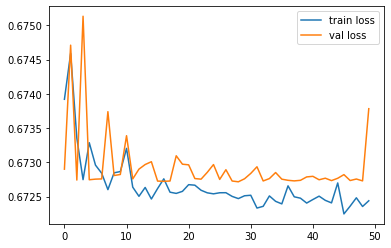

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

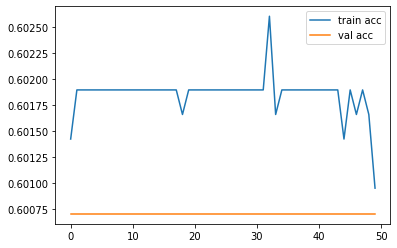

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(hist.history['precision_7'], label='train acc')
plt.plot(hist.history['val_precision_7'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
# Calculate the accuracy
test_preds = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
test_acc = np.sum(test_preds == y_true)/y_true.shape[0]

# Recall for each class
recall_vals = []
for i in range(3):
    class_idx = np.argwhere(y_true==i)
    total = len(class_idx)
    correct = np.sum(test_preds[class_idx]==i)
    recall = correct / total
    recall_vals.append(recall)

classes = [0,1]
# Calculate the test set accuracy and recall for each class
print('Test set accuracy is {:.3f}'.format(test_acc))
for i in range(2):
    print('For class {}, recall is {:.3f}'.format(classes[i],recall_vals[i]))

print("Weighted F score is {:.3f}".format(test_acc))
# print("Weighted F score is {:.3f}".format(calculate_weighted_f_score(y_true, y_pred)))

Test set accuracy is 0.608
For class 0, recall is 1.000
For class 1, recall is 0.000
Weighted F score is 0.608


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


#Keras Model TCN Conv2D

In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Flatten, Dense, Activation
from keras.utils import np_utils
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, Nadam


In [ ]:
#pip install keras-tcn
from tcn import TCN

In [ ]:
###### ONLY EXECUTE FOR KERAS 2D CNN #####

X_train_2d = X_train.reshape(X_train.shape[0], 
                          X_train.shape[1], 
                          X_train.shape[2],
                          1
                          )
X_val_2d = X_val.reshape(X_val.shape[0],
                          X_val.shape[1], 
                          X_val.shape[2],
                          1
                          )
X_test_2d = X_test.reshape(X_test.shape[0],
                          X_test.shape[1], 
                          X_test.shape[2],
                          1
                          )

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

In [ ]:
print(f'X Train Length {X_train_2d.shape}, y Train Label Length {y_train.shape}')
print(f'X Val Length {X_val_2d.shape}, y Val Label Length {y_val.shape}')
print(f'X Test Length {X_test_2d.shape}, y Test Label Length {y_test.shape}')

X Train Length (4060, 5, 24, 1), y Train Label Length (4060, 2)
X Val Length (1435, 5, 24, 1), y Val Label Length (1435, 2)
X Test Length (1090, 5, 24, 1), y Test Label Length (1090, 2)


In [ ]:
# data_format='channels_first'
#Create model
model = Sequential()
model.add(Convolution2D(filters=32, kernel_size=(1, 4), padding='same', activation='relu', input_shape=(X_train_2d.shape[1],X_train_2d.shape[2],X_train_2d.shape[3])))
model.add(MaxPooling2D(pool_size=(1,4), strides=(1, 4), padding='same'))
model.add(Dropout(0.7))
model.add(TCN(return_sequences=False))
# model.add(Convolution2D(filters=64, kernel_size=(1,3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(1,3), strides=(1, 3), padding='same'))
# model.add(Dropout(0.7))
# model.add(Convolution2D(filters=128, kernel_size=(1,2), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2), padding='same'))
# model.add(Dropout(0.7))
# model.add(Flatten())
model.add(Dense(1000,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(3,activation="softmax"))
model.summary()

ValueError: ignored

In [ ]:
adam = Adam(learning_rate=0.001, decay=0.0001)
nadam = Nadam(learning_rate=0.002, schedule_decay=0.004)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=["accuracy"]) 

In [ ]:
batch_size = 12
hist = model.fit(X_train_2d, y_train, batch_size=batch_size, epochs=350, validation_data=(X_val_2d, y_val)) #, class_weight={0:1, 1:1.5})

Epoch 1/350
338/338 [==============================] - 9s 21ms/step - loss: 1.1181 - accuracy: 0.3988 - val_loss: 1.0789 - val_accuracy: 0.4210
Epoch 2/350
338/338 [==============================] - 7s 20ms/step - loss: 1.0796 - accuracy: 0.4197 - val_loss: 1.0738 - val_accuracy: 0.4189
Epoch 3/350
338/338 [==============================] - 7s 20ms/step - loss: 1.0775 - accuracy: 0.4229 - val_loss: 1.0732 - val_accuracy: 0.4182
Epoch 4/350
338/338 [==============================] - 7s 21ms/step - loss: 1.0739 - accuracy: 0.4266 - val_loss: 1.0721 - val_accuracy: 0.4189
Epoch 5/350
338/338 [==============================] - 8s 25ms/step - loss: 1.0715 - accuracy: 0.4252 - val_loss: 1.0666 - val_accuracy: 0.4175
Epoch 6/350
338/338 [==============================] - 7s 21ms/step - loss: 1.0744 - accuracy: 0.4192 - val_loss: 1.0659 - val_accuracy: 0.4203
Epoch 7/350
 39/338 [==>...........................] - ETA: 5s - loss: 1.0857 - accuracy: 0.4060

In [ ]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

In [ ]:
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
y_pred = model.predict(X_test_2d)

In [ ]:
y_pred

In [ ]:
# Calculate the accuracy
test_preds = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
test_acc = np.sum(test_preds == y_true)/y_true.shape[0]

# Recall for each class
recall_vals = []
for i in range(3):
    class_idx = np.argwhere(y_true==i)
    total = len(class_idx)
    correct = np.sum(test_preds[class_idx]==i)
    recall = correct / total
    recall_vals.append(recall)

classes = [0,1,2]
# Calculate the test set accuracy and recall for each class
print('Test set accuracy is {:.3f}'.format(test_acc))
for i in range(3):
    print('For class {}, recall is {:.3f}'.format(classes[i],recall_vals[i]))

print("Accuracy is {:.3f}".format(test_acc))
# print("Weighted F score is {:.3f}".format(calculate_weighted_f_score(y_true, y_pred)))

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

nb_classes = 3

# Confusion matrix
conf_mat=confusion_matrix(y_true, np.argmax(y_pred, axis=-1))
plot_confusion_matrix(conf_mat, ["flat","down","up"])

from sklearn.metrics import precision_score

precision_score(y_true, np.argmax(y_pred, axis=-1), average='weighted')

from sklearn.metrics import classification_report

print(classification_report(y_true, np.argmax(y_pred, axis=-1), target_names=["flat","down", "up"], digits=4))

In [ ]:
def calculate_weighted_f_score(y_true, y_pred):
  test_preds = np.argmax(y_pred, axis=-1)
  Ntu = sum((test_preds == 2) & (y_true == 2))
  Ntd = sum((test_preds == 1) & (y_true == 1))
  Ntf = sum((test_preds == 0) & (y_true == 0))
  Ewutd = sum((test_preds == 2) & (y_true == 1))
  Ewdtu = sum((test_preds == 1) & (y_true == 2))
  Ewutf = sum((test_preds == 2) & (y_true == 0))
  Ewdtf = sum((test_preds == 1) & (y_true == 0))
  Ewftu = sum((test_preds == 0) & (y_true == 2))
  Ewftd = sum((test_preds == 0) & (y_true == 1))

  beta_1 = 0.5
  beta_2 = 0.125
  beta_3 = 0.125

  Ntp = Ntu + Ntd + beta_3**2 * Ntf
  E1 = Ewutd + Ewdtu
  E2 = Ewutf + Ewdtf
  E3 = Ewftu + Ewftd

  F = (1 + beta_1**2 + beta_2**2) * Ntp / ((1+beta_1**2+beta_2**2) * Ntp + E1 + beta_1**2 * E2 + beta_2**2 * E3)
  return  F

print(f'Weight CDT F Score: {calculate_weighted_f_score(y_true, y_pred)}')

# Completely New Model Build

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

In [ ]:
model = Sequential()
model.add(Conv2D(32, (1, 3), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
model.add(MaxPooling2D((1, 4), strides=4))
model.add(Dropout(0.7))
model.add(Conv2D(64, (1, 3), activation='relu', padding='same',))
model.add(MaxPooling2D((1, 3), strides=3))
model.add(Dropout(0.7))
model.add(Conv2D(128, (1, 3), activation='relu', padding='same',))
model.add(MaxPooling2D((1, 2), strides=2))
model.add(Dropout(0.7))

model.add(Flatten())
model.add(Dense(1000,activation="relu"))
model.add(Dense(500,activation="relu"))
model.add(Dense(3,activation="softmax"))

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 5, 24, 32)         128       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 2, 6, 32)         0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 2, 6, 32)          0         
                                                                 
 conv2d_23 (Conv2D)          (None, 2, 6, 64)          6208      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 1, 2, 64)         0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 1, 2, 64)         

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy']) 

In [ ]:
batch_size = 12
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_data=(X_val, y_val))

##### LABLES NEED TO BY 1x3 ARRAY

Epoch 1/50
352/352 [==============================] - 10s 5ms/step - loss: 1.1026 - accuracy: 0.3635 - val_loss: 1.0981 - val_accuracy: 0.3671
Epoch 2/50
352/352 [==============================] - 2s 5ms/step - loss: 1.0940 - accuracy: 0.3780 - val_loss: 1.0986 - val_accuracy: 0.3671
Epoch 3/50
352/352 [==============================] - 2s 5ms/step - loss: 1.0958 - accuracy: 0.3765 - val_loss: 1.0988 - val_accuracy: 0.3671
Epoch 4/50
352/352 [==============================] - 2s 5ms/step - loss: 1.0938 - accuracy: 0.3770 - val_loss: 1.0990 - val_accuracy: 0.3671
